Data can be found here:

https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/downloads/human-activity-recognition-with-smartphones.zip  

In [278]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 2 - Load and analyse the data

In [2]:
train = pd.read_csv("./har_data/train.csv")
test = pd.read_csv("./har_data/test.csv")

In [3]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


## FIXME: group folds on subject

In [7]:
train.drop('subject', axis =1, inplace=True)
test.drop('subject', axis =1, inplace=True)

In [33]:
for x in [train, test]:
    x['Activity'] = x.Activity.astype("category")

## 4 - Splitting the data into train and validation 

In [189]:
#Getting the split indexes

split_data = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
train_idx, val_idx = next(split_data.split(train[feature_cols], train.Activity))

#creating the dataframes

x_train = train.loc[train_idx, feature_cols]
y_train = train.loc[train_idx, 'Activity']

x_val = train.loc[val_idx, feature_cols]
y_val = train.loc[val_idx, 'Activity']

## 5 - Predictive Modelling

In [177]:
from sklearn.feature_selection import VarianceThreshold

v = VarianceThreshold(threshold=0.2)
x_train = v.fit_transform(x_train)
x_val = v.transform(x_val)
x_val.shape

(2206, 58)

In [178]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.001, penalty="l1", max_iter=10000, dual=False).fit(StandardScaler().fit_transform(x_train), y_train)
model = SelectFromModel(lsvc, prefit=True)
xx = model.transform(x_train)
xx.shape


(5146, 18)

In [279]:

splitter = StratifiedShuffleSplit(n_splits = 3, test_size = 0.3, random_state = 42)
from sklearn.feature_selection import SequentialFeatureSelector

s = SequentialFeatureSelector(estimator=LogisticRegression(C=1.0, max_iter=1000),
                              n_features_to_select=40,
                              direction='forward',
                              scoring='accuracy',
                              n_jobs=4,
                              cv=splitter)
s.fit(x_train, y_train)


#KNeighborsClassifier(n_neighbors=3), n_features_to_select=3


KeyboardInterrupt: 

In [180]:
x_train = s.transform(x_train)
x_train.shape

(5146, 10)

In [181]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators = 30)

cross_val_score(rf, x_train, y_train)


array([0.91747573, 0.93197279, 0.91836735, 0.93683188, 0.92322643])

In [93]:
x_train.shape

(5146, 58)

In [157]:
from sklearn.svm import NuSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svc = NuSVC(nu=0.10,
      kernel='linear',
      #gamma='scale',
      shrinking=True,
      tol=0.001,
      cache_size=200,
      verbose=False,
      max_iter=100000,
      decision_function_shape='ovr',
      break_ties=False,
      random_state=None)

pipe = make_pipeline(StandardScaler(), svc)

scores = cross_val_score(pipe, x_train, y_train)
print(scores)
pipe.fit(x_train, y_train)
print(np.sum(pipe.named_steps['nusvc'].n_support_))


[0.75145631 0.63848397 0.39067055 0.52380952 0.71137026]
1388


In [ ]:
# Seems like NuSVC has a quite small range for the support vectors

In [164]:


from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

svc = SVC(C=100.0, max_iter=100000, kernel='linear')
pipe = make_pipeline(StandardScaler(), svc)
scores = cross_val_score(pipe, x_train, y_train)
print(scores)
pipe.fit(x_train, y_train)
print(pipe.named_steps)
print(np.sum(pipe.named_steps['svc'].n_support_))


[0.84757282 0.83187561 0.85519922 0.84645287 0.86297376]
{'standardscaler': StandardScaler(), 'svc': SVC(C=100.0, kernel='linear', max_iter=100000)}
1869


In [ ]:
# LinearSVC has both a larger range for the support vectors, and a lower number for better performance

In [188]:

from sklearn.linear_model import LogisticRegression

svc = LogisticRegression(C=10.0, max_iter=10000)

pipe = make_pipeline(StandardScaler(), svc)

scores = cross_val_score(pipe, x_train, y_train)
print(scores)
pipe.fit(x_train, y_train)
print(pipe.named_steps['logisticregression'].coef_.shape)


[0.90291262 0.88921283 0.88726919 0.89990282 0.9047619 ]
(6, 10)


In [284]:
from sklearn.linear_model import LogisticRegression

def scores_to_error(scores):
    err = (1.0 - scores)*100
    return err

def check_sparse_logreg(x_train, y_train, C=1.0, weight_minimum=0.5, cv=5):

    # Define model
    est = LogisticRegression(C=C, penalty='l1', solver='liblinear', max_iter=10000)
    pipe = make_pipeline(StandardScaler(), est)
    
    # Estimate perf with all features
    scores_full = scores_to_error(cross_val_score(pipe, x_train, y_train, cv=cv))

    # Figure out which features to select/remove
    # FIXME: use SelectFromModel?
    pipe.fit(x_train, y_train)
    
    c = pipe.named_steps['logisticregression'].coef_
    weights_selected = np.count_nonzero(c)/np.prod(c.shape)
    
    feature_weights = np.sum(np.abs(c), axis=0)
    features_removed = feature_weights <= weight_minimum

    # Estimate perf with subset features
    selected_columns = x_train.columns[~features_removed]
    x_train_cut = x_train[selected_columns]
    scores = scores_to_error(cross_val_score(pipe, x_train_cut, y_train, cv=cv))

    results = pandas.Series({
        'features_selected': len(selected_columns),
        'cv_scores_full': scores_full,
        'cv_scores_reduced': scores,
        'C': C,
        'weight_minimum': weight_minimum,
    })
    return results

complexities = np.logspace(-3, +3, 20)
out = []
for C in complexities:
    r  = check_sparse_logreg(x_train, y_train, C=C)
    out.append(r)
results = pandas.DataFrame(out)

In [285]:
results

,features_selected,cv_scores_full,cv_scores_reduced,C,weight_minimum
0,1,"[60.77669902912621, 61.51603498542274, 61.3216...","[62.13592233009708, 62.09912536443149, 62.1963...",0.001000,0.5
1,3,"[19.029126213592228, 21.28279883381924, 17.589...","[49.51456310679612, 49.17395529640428, 49.3683...",0.002069,0.5
2,7,"[9.514563106796114, 12.82798833819242, 11.2730...","[25.24271844660194, 25.267249757045672, 23.809...",0.004281,0.5
3,14,"[7.7669902912621325, 9.7181729834791, 9.426627...","[12.038834951456312, 13.79980563654033, 12.633...",0.008859,0.5
4,25,"[4.854368932038833, 6.99708454810496, 6.802721...","[7.18446601941748, 8.843537414965985, 7.774538...",0.018330,0.5
5,38,"[2.9126213592232997, 4.178814382896013, 5.2478...","[4.660194174757281, 5.053449951409139, 5.83090...",0.037927,0.5
6,54,"[2.135922330097084, 3.0126336248785246, 3.4985...","[3.1067961165048508, 3.5957240038872684, 4.275...",0.078476,0.5
7,70,"[1.3592233009708687, 2.7210884353741527, 2.526...","[1.844660194174752, 2.0408163265306145, 2.6239...",0.162378,0.5
8,96,"[1.3592233009708687, 1.9436345966958202, 2.137...","[1.2621359223300987, 1.4577259475218707, 2.040...",0.335982,0.5
9,138,"[1.553398058252431, 1.9436345966958202, 2.2351...","[1.1650485436893177, 1.4577259475218707, 1.846...",0.695193,0.5


In [287]:
results.to_csv('logreg-l1-feature-selection-2.csv')
del results

In [311]:
results = pandas.read_csv('logreg-l1-feature-selection.csv')

def load_csv_embedded_array(s):
    def load_one(vv):
        l = [ float(p.strip()) for p in vv.strip('[]').split(' ') if p.strip() ]
        return l
    return s.apply(load_one)
    
for c in ['cv_scores_full', 'cv_scores_reduced']:
    results[c] = load_csv_embedded_array(results[c])

results.head()

,Unnamed: 0,features_selected,cv_scores_full,cv_scores_reduced,C,weight_minimum
0,0,1,"[60.77669903, 61.51603499, 61.32167153, 61.418...","[62.13592233, 62.09912536, 62.19630709, 62.196...",0.001000,0.5
1,1,3,"[19.02912621, 21.28279883, 17.5898931, 20.6025...","[49.51456311, 49.1739553, 49.36831876, 49.3683...",0.002069,0.5
2,2,7,"[9.51456311, 12.82798834, 11.27308066, 8.84353...","[25.24271845, 25.26724976, 23.80952381, 24.489...",0.004281,0.5
3,3,14,"[7.76699029, 9.71817298, 9.42662779, 7.5801749...","[12.03883495, 13.79980564, 12.63362488, 10.106...",0.008859,0.5
4,4,25,"[4.85436893, 6.99708455, 6.80272109, 4.1788143...","[7.18446602, 8.84353741, 7.77453839, 5.3449951...",0.018330,0.5


In [312]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

#def mean_confidence_err(data, **kwargs):
#    mean, lower, upper = mean_confidence_interval(data, **kwargs)
#    return 

results['scores_full_mean'] = results['cv_scores_full'].apply(np.mean)
#results['scores_full_ci'] = results['cv_scores_full'].apply(mean_confidence_interval)

results['scores_reduced_mean'] = results['cv_scores_reduced'].apply(np.mean)
#results['scores_reduced_ci'] = results['cv_scores_reduced'].apply(mean_confidence_interval)

results = results.drop(columns=['cv_scores_full', 'cv_scores_reduced'])

results

,Unnamed: 0,features_selected,C,weight_minimum,scores_full_mean,scores_reduced_mean
0,0,1,0.001000,0.5,61.173804,62.164794
1,1,3,0.002069,0.5,19.801938,49.358695
2,2,7,0.004281,0.5,10.241105,24.659817
3,3,14,0.008859,0.5,8.103447,11.892704
4,4,25,0.018330,0.5,5.382924,6.976252
5,5,38,0.037927,0.5,3.692340,4.411145
6,6,54,0.078476,0.5,2.584619,3.070339
7,7,70,0.162378,0.5,2.040552,2.059894
8,8,96,0.335982,0.5,1.787880,1.593535
9,9,138,0.695193,0.5,1.729533,1.399190


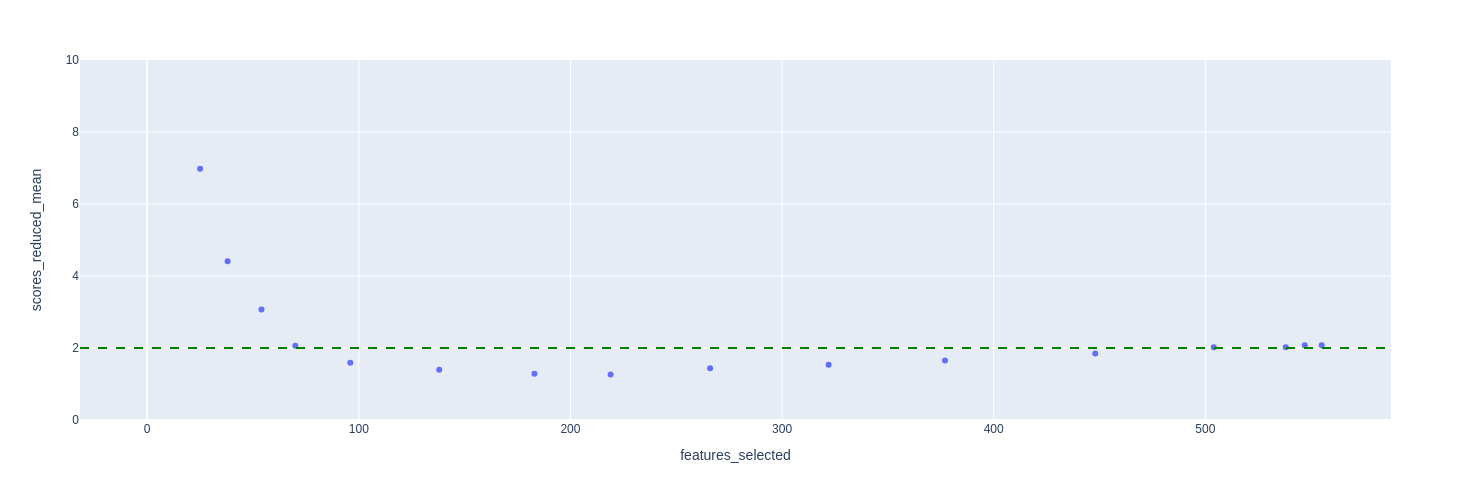

In [324]:

import plotly
import plotly.express

# FIXME: plot both full and reduced, in separate colors
# FIXME: add error bars
# TODO: include other data on hover, like complexity value
fig = plotly.express.scatter(results,
                 x="features_selected",
                 y="scores_reduced_mean",
                 #color="species",
                 #error_y="scores_reduced_mean",
)
fig.update_layout(height=500, width=800,)
fig.add_hline(y=2.0, line_width=2, line_dash="dash", line_color="green")
fig.update_yaxes(range=[0.0, 10.0])
fig.show()
